Modelling crime risk associated with Green Spaces
---
A case study of New York City using NYPD Complaint Data and Machine Learning models

| Authors                        | Student ID   |
|--------------------------------|--------------|
| Kaninik Baradi                 | 5216664      |
| Lala Sayyida Millati Nadhira   | 5844266      |
| Rezzy Yolanda Wulandhari       | 4779487      |
| Kelvin Engee                   | 4664043      |
| Philippe Almeida Mirault       | 5898803      |
Group 4

For the course: Responsible Data Analytics, SEN 163B
April 2023

# Introduction
This notebook is a companion to the report on Modelling Crime Risks associated with Green spaces. It contains all the code required to download, pre-process and analyse the data. The notebook is divided into the following sections:
- Preparation
- Descriptive Analytics
    - Preliminary Analysis
- Diagnostic Analytics
    - Feature Analysis
    - Feature Engineering
    - Bias Analysis
- Predictive Analysis
    - Target Variable Analysis
    - Train-Test Split Strategy
    - Model Evaluation
    - Model Interpretation
- Prescriptive Analysis
    - Cross Validation
    - Ensemble Predictor
    - Model Deployment

# Preparation

Dependencies:

Data Sources:

In [8]:
import pandas
import altair
import numpy
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import seaborn as sns

# Descriptive Analytics
This section contains the initial analysis of the selected data sets. It identifies the underlying relationships of the variables and if used to determine vriables of interest for further analysis.

## Complaints Data

In [9]:
crime_data = pandas.read_csv("..\\NYPD_Complaint_Data_Historic.csv")

C:\Users\Kaninik Baradi\AppData\Local\Temp\ipykernel_26584\2592922670.py:1: DtypeWarning: Columns (18,20) have mixed types. Specify dtype option on import or set low_memory=False.
  crime_data = pandas.read_csv("..\\NYPD_Complaint_Data_Historic.csv")


In [10]:
def make_categorical(dataframe, column):
    # make the column of the dataframe categorical
    dataframe[column] = dataframe[column].astype('category')

# get a lst of all the columns in the dataframe that need to be categorical

columns = ['ADDR_PCT_CD', 'BORO_NM', 'CRM_ATPT_CPTD_CD', 'HADEVELOPT', 'HOUSING_PSA', 'JURISDICTION_CODE', 'JURIS_DESC', 'KY_CD', 'LAW_CAT_CD', 'LOC_OF_OCCUR_DESC', 'OFNS_DESC', 'PARKS_NM', 'PATROL_BORO', 'PD_CD', 'PD_DESC', 'STATION_NAME', 'SUSP_RACE', 'SUSP_SEX', 'TRANSIT_DISTRICT', 'VIC_RACE', 'VIC_SEX']

    # make each column categorical
for column in columns:
    make_categorical(crime_data, column)

#scrub for duplicate
crime_data.drop_duplicates(inplace=True)

In [11]:
#scrub for irrelevant data (only use required columns)
crime_data = crime_data[['CMPLNT_FR_DT','CMPLNT_FR_TM','Longitude','Latitude','VIC_SEX','VIC_RACE','VIC_AGE_GROUP']]


In [12]:
crime_data

,CMPLNT_FR_DT,CMPLNT_FR_TM,Longitude,Latitude,VIC_SEX,VIC_RACE,VIC_AGE_GROUP
0,03/29/2018,20:30:00,-73.941064,40.810877,F,WHITE,25-44
1,02/06/2018,23:15:00,-73.908014,40.873671,D,UNKNOWN,UNKNOWN
2,11/21/2018,00:15:00,-73.885457,40.651782,D,UNKNOWN,UNKNOWN
3,06/09/2018,21:42:00,-73.994706,40.759310,F,WHITE HISPANIC,18-24
4,11/10/2018,19:40:00,-73.970728,40.764536,D,UNKNOWN,UNKNOWN
...,...,...,...,...,...,...,...
7825494,05/01/2008,18:55:00,-73.996540,40.756788,E,UNKNOWN,UNKNOWN
7825495,05/18/2018,14:50:00,-74.102317,40.577953,M,WHITE HISPANIC,<18
7825496,11/19/2018,02:25:00,-73.862427,40.743188,M,ASIAN / PACIFIC ISLANDER,25-44
7825497,02/03/2018,10:02:00,-74.089000,40.593665,M,WHITE,45-64


In [13]:
#unlike usual, all the rows with missing data is deleted beforehand, because there all the data is missing completely at random
missing_counts = crime_data.isna().sum()

print(missing_counts)

CMPLNT_FR_DT         655
CMPLNT_FR_TM          48
Longitude          17339
Latitude           17339
VIC_SEX              308
VIC_RACE             390
VIC_AGE_GROUP    1638445
dtype: int64


In [14]:
crime_data = crime_data.dropna(axis=0)

print(crime_data)

        CMPLNT_FR_DT CMPLNT_FR_TM  Longitude   Latitude VIC_SEX   
0         03/29/2018     20:30:00 -73.941064  40.810877       F  \
1         02/06/2018     23:15:00 -73.908014  40.873671       D   
2         11/21/2018     00:15:00 -73.885457  40.651782       D   
3         06/09/2018     21:42:00 -73.994706  40.759310       F   
4         11/10/2018     19:40:00 -73.970728  40.764536       D   
...              ...          ...        ...        ...     ...   
7825494   05/01/2008     18:55:00 -73.996540  40.756788       E   
7825495   05/18/2018     14:50:00 -74.102317  40.577953       M   
7825496   11/19/2018     02:25:00 -73.862427  40.743188       M   
7825497   02/03/2018     10:02:00 -74.089000  40.593665       M   
7825498   01/05/2018     14:40:00 -73.944529  40.688872       F   

                         VIC_RACE VIC_AGE_GROUP  
0                           WHITE         25-44  
1                         UNKNOWN       UNKNOWN  
2                         UNKNOWN       UNKNO

In [15]:
#unlike usual, all the rows with missing data is deleted beforehand, because there all the data is missing completely at random
missing_counts = crime_data.isna().sum()

print(missing_counts)

CMPLNT_FR_DT     0
CMPLNT_FR_TM     0
Longitude        0
Latitude         0
VIC_SEX          0
VIC_RACE         0
VIC_AGE_GROUP    0
dtype: int64


# CMPLNT_FR_DT


In [16]:
crime_data[['month','day','year']] = crime_data['CMPLNT_FR_DT'].str.split('/',expand=True).astype(int)

C:\Users\Kaninik Baradi\AppData\Local\Temp\ipykernel_26584\3669391758.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crime_data[['month','day','year']] = crime_data['CMPLNT_FR_DT'].str.split('/',expand=True).astype(int)
C:\Users\Kaninik Baradi\AppData\Local\Temp\ipykernel_26584\3669391758.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crime_data[['month','day','year']] = crime_data['CMPLNT_FR_DT'].str.split('/',expand=True).astype(int)
C:\Users\Kaninik Baradi\AppData\Local\Temp\ipykernel_26584\366

In [17]:
crime_data

,CMPLNT_FR_DT,CMPLNT_FR_TM,Longitude,Latitude,VIC_SEX,VIC_RACE,VIC_AGE_GROUP,month,day,year
0,03/29/2018,20:30:00,-73.941064,40.810877,F,WHITE,25-44,3,29,2018
1,02/06/2018,23:15:00,-73.908014,40.873671,D,UNKNOWN,UNKNOWN,2,6,2018
2,11/21/2018,00:15:00,-73.885457,40.651782,D,UNKNOWN,UNKNOWN,11,21,2018
3,06/09/2018,21:42:00,-73.994706,40.759310,F,WHITE HISPANIC,18-24,6,9,2018
4,11/10/2018,19:40:00,-73.970728,40.764536,D,UNKNOWN,UNKNOWN,11,10,2018
...,...,...,...,...,...,...,...,...,...,...
7825494,05/01/2008,18:55:00,-73.996540,40.756788,E,UNKNOWN,UNKNOWN,5,1,2008
7825495,05/18/2018,14:50:00,-74.102317,40.577953,M,WHITE HISPANIC,<18,5,18,2018
7825496,11/19/2018,02:25:00,-73.862427,40.743188,M,ASIAN / PACIFIC ISLANDER,25-44,11,19,2018
7825497,02/03/2018,10:02:00,-74.089000,40.593665,M,WHITE,45-64,2,3,2018


In [18]:
crime_data = crime_data.loc[crime_data['year'] >= 2006]

In [19]:
crime_data['CMPLNT_FR_DT'] = pandas.to_datetime(crime_data['CMPLNT_FR_DT'], format='%m/%d/%Y')
crime_data['day_of_week'] = crime_data['CMPLNT_FR_DT'].dt.dayofweek

C:\Users\Kaninik Baradi\AppData\Local\Temp\ipykernel_26584\2150539645.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crime_data['CMPLNT_FR_DT'] = pandas.to_datetime(crime_data['CMPLNT_FR_DT'], format='%m/%d/%Y')
C:\Users\Kaninik Baradi\AppData\Local\Temp\ipykernel_26584\2150539645.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crime_data['day_of_week'] = crime_data['CMPLNT_FR_DT'].dt.dayofweek


In [20]:
crime_data = crime_data.drop('CMPLNT_FR_DT', axis=1)
crime_data = crime_data.drop('month', axis=1)
crime_data = crime_data.drop('day', axis=1)
crime_data

,CMPLNT_FR_TM,Longitude,Latitude,VIC_SEX,VIC_RACE,VIC_AGE_GROUP,year,day_of_week
0,20:30:00,-73.941064,40.810877,F,WHITE,25-44,2018,3
1,23:15:00,-73.908014,40.873671,D,UNKNOWN,UNKNOWN,2018,1
2,00:15:00,-73.885457,40.651782,D,UNKNOWN,UNKNOWN,2018,2
3,21:42:00,-73.994706,40.759310,F,WHITE HISPANIC,18-24,2018,5
4,19:40:00,-73.970728,40.764536,D,UNKNOWN,UNKNOWN,2018,5
...,...,...,...,...,...,...,...,...
7825494,18:55:00,-73.996540,40.756788,E,UNKNOWN,UNKNOWN,2008,3
7825495,14:50:00,-74.102317,40.577953,M,WHITE HISPANIC,<18,2018,4
7825496,02:25:00,-73.862427,40.743188,M,ASIAN / PACIFIC ISLANDER,25-44,2018,0
7825497,10:02:00,-74.089000,40.593665,M,WHITE,45-64,2018,5


# CMPLNT_FR_TM

In [21]:
crime_data[['hour','minute','second']] = crime_data['CMPLNT_FR_TM'].str.split(':',expand=True).astype(int)

In [22]:
crime_data = crime_data.drop('CMPLNT_FR_TM', axis=1)
crime_data = crime_data.drop('second', axis=1)
crime_data = crime_data.drop('minute', axis=1)
crime_data

,Longitude,Latitude,VIC_SEX,VIC_RACE,VIC_AGE_GROUP,year,day_of_week,hour
0,-73.941064,40.810877,F,WHITE,25-44,2018,3,20
1,-73.908014,40.873671,D,UNKNOWN,UNKNOWN,2018,1,23
2,-73.885457,40.651782,D,UNKNOWN,UNKNOWN,2018,2,0
3,-73.994706,40.759310,F,WHITE HISPANIC,18-24,2018,5,21
4,-73.970728,40.764536,D,UNKNOWN,UNKNOWN,2018,5,19
...,...,...,...,...,...,...,...,...
7825494,-73.996540,40.756788,E,UNKNOWN,UNKNOWN,2008,3,18
7825495,-74.102317,40.577953,M,WHITE HISPANIC,<18,2018,4,14
7825496,-73.862427,40.743188,M,ASIAN / PACIFIC ISLANDER,25-44,2018,0,2
7825497,-74.089000,40.593665,M,WHITE,45-64,2018,5,10


# Grid the Longitude and Latitude

In [23]:
# Create a grid of points across the precincts to use as the center of the crime clusters
# The size of the grid is n x n, where n is the number of points in each direction
from shapely.geometry import Point, Polygon
from rtree import index

precint_footprint = gpd.read_file('..//data//Police Precincts.geojson')

# get the bounds of the precincts
min_x, min_y, max_x, max_y = precint_footprint.total_bounds

idx = index.Index()
for i, row in precint_footprint.iterrows():
    idx.insert(i, row.geometry.bounds)

grid_size = 100  # You can adjust this value
x_points = np.linspace(min_x, max_x, grid_size)
y_points = np.linspace(min_y, max_y, grid_size)

# Round the points to 4 decimal places
x_points = np.around(x_points, 5)
y_points = np.around(y_points, 5)

grid = [Point(x, y) for x in x_points for y in y_points]

# drop the points that are not within the precincts
def is_point_inside_precincts(point, precincts_gdf, idx):
    for i in idx.intersection(point.bounds):
        if point.within(precincts_gdf.iloc[i].geometry):
            return True
    return False

filtered_grid = [point for point in grid if is_point_inside_precincts(point, precint_footprint, idx)]
filtered_grid_df = pandas.DataFrame([(point.x, point.y) for point in filtered_grid], columns=['Longitude', 'Latitude'])
#
del grid
del filtered_grid

In [24]:
from scipy.spatial import cKDTree

# create a KD Tree with the Longitude and Latitude columns of filtered_grid_df
kd_tree = cKDTree(filtered_grid_df[['Longitude', 'Latitude']])

def nearest_grid_point(coord, grid_points):
    nearest_index = np.argmin(np.abs(coord - grid_points))
    return grid_points[nearest_index]

In [25]:

# query the KD Tree with the Longitude and Latitude columns of crime_data
distances, indices = kd_tree.query(crime_data[['Longitude', 'Latitude']])

# use the indices to get the corresponding Longitude and Latitude values from filtered_grid_df
crime_data['Longitude'] = filtered_grid_df.loc[indices, 'Longitude'].values
crime_data['Latitude'] = filtered_grid_df.loc[indices, 'Latitude'].values

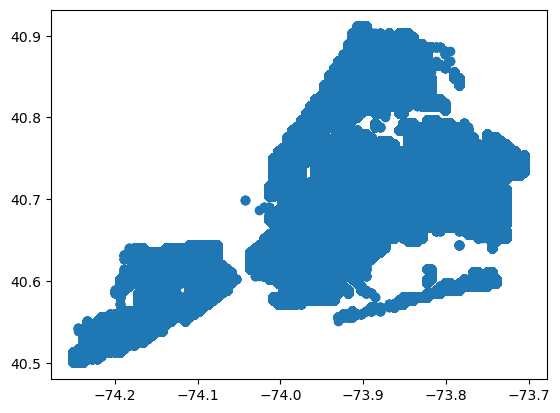

In [26]:
plt.scatter(crime_data['Longitude'], crime_data['Latitude'])

In [27]:
crime_data = crime_data.loc[crime_data['Longitude'] > -74.5]

In [28]:
crime_data = crime_data.loc[crime_data['Latitude'] < 42.5]

In [29]:
crime_data

,Longitude,Latitude,VIC_SEX,VIC_RACE,VIC_AGE_GROUP,year,day_of_week,hour
0,-73.94132,40.80962,F,WHITE,25-44,2018,3,20
1,-73.90765,40.87317,D,UNKNOWN,UNKNOWN,2018,1,23
2,-73.88520,40.65288,D,UNKNOWN,UNKNOWN,2018,2,0
3,-73.99744,40.75879,F,WHITE HISPANIC,18-24,2018,5,21
4,-73.96938,40.76302,D,UNKNOWN,UNKNOWN,2018,5,19
...,...,...,...,...,...,...,...,...
7825494,-73.99744,40.75879,E,UNKNOWN,UNKNOWN,2008,3,18
7825495,-74.10407,40.57662,M,WHITE HISPANIC,<18,2018,4,14
7825496,-73.86276,40.74184,M,ASIAN / PACIFIC ISLANDER,25-44,2018,0,2
7825497,-74.08723,40.59357,M,WHITE,45-64,2018,5,10


# VIC_SEX

In [30]:
crime_data['VIC_SEX'].unique()

['F', 'D', 'E', 'M', 'U']
Categories (5, object): ['D', 'E', 'F', 'M', 'U']

In [31]:
# Only keep the M and F sex values
sexes = ['M', 'F']

crime_data = crime_data.loc[crime_data['VIC_SEX'].isin(sexes)]
# Re calculate the categories for the Sex column
crime_data['VIC_SEX'] = crime_data['VIC_SEX'].cat.remove_unused_categories()

del sexes
crime_data.head(5)

C:\Users\Kaninik Baradi\AppData\Local\Temp\ipykernel_26584\451495837.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crime_data['VIC_SEX'] = crime_data['VIC_SEX'].cat.remove_unused_categories()


,Longitude,Latitude,VIC_SEX,VIC_RACE,VIC_AGE_GROUP,year,day_of_week,hour
0,-73.94132,40.80962,F,WHITE,25-44,2018,3,20
3,-73.99744,40.75879,F,WHITE HISPANIC,18-24,2018,5,21
8,-73.91326,40.63593,M,BLACK,<18,2018,1,14
9,-73.91887,40.82657,F,WHITE HISPANIC,25-44,2018,5,22
10,-73.95255,40.80539,M,BLACK,25-44,2018,2,18


In [32]:
crime_data['VIC_SEX'].unique()

['F', 'M']
Categories (2, object): ['F', 'M']

# VIC_RACE


In [33]:
crime_data['VIC_RACE'].unique()

['WHITE', 'WHITE HISPANIC', 'BLACK', 'ASIAN / PACIFIC ISLANDER', 'BLACK HISPANIC', 'UNKNOWN', 'AMERICAN INDIAN/ALASKAN NATIVE', 'OTHER']
Categories (8, object): ['AMERICAN INDIAN/ALASKAN NATIVE', 'ASIAN / PACIFIC ISLANDER', 'BLACK', 'BLACK HISPANIC', 'OTHER', 'UNKNOWN', 'WHITE', 'WHITE HISPANIC']

In [34]:
# Keep everything except for UNKNOWN and OTHER
races = ['WHITE', 'WHITE HISPANIC', 'BLACK','ASIAN / PACIFIC ISLANdER', 'BLACK HISPANIC','AMERICAN INDIAN/ALASKAN NATIVE', 'OTHER']

crime_data = crime_data.loc[crime_data['VIC_RACE'].isin(races)]
# Re calculate the categories for the Sex column
crime_data['VIC_RACE'] = crime_data['VIC_RACE'].cat.remove_unused_categories()

del races
crime_data.head(5)

,Longitude,Latitude,VIC_SEX,VIC_RACE,VIC_AGE_GROUP,year,day_of_week,hour
0,-73.94132,40.80962,F,WHITE,25-44,2018,3,20
3,-73.99744,40.75879,F,WHITE HISPANIC,18-24,2018,5,21
8,-73.91326,40.63593,M,BLACK,<18,2018,1,14
9,-73.91887,40.82657,F,WHITE HISPANIC,25-44,2018,5,22
10,-73.95255,40.80539,M,BLACK,25-44,2018,2,18


In [35]:
crime_data['VIC_RACE'].unique()

['WHITE', 'WHITE HISPANIC', 'BLACK', 'BLACK HISPANIC', 'AMERICAN INDIAN/ALASKAN NATIVE', 'OTHER']
Categories (6, object): ['AMERICAN INDIAN/ALASKAN NATIVE', 'BLACK', 'BLACK HISPANIC', 'OTHER', 'WHITE', 'WHITE HISPANIC']

# VIC_AGE_GROUP

In [36]:
crime_data['VIC_AGE_GROUP'].unique()

array(['25-44', '18-24', '<18', '45-64', '65+', 'UNKNOWN', '-942', '1017',
       '-51', '954', '972', '951', '-55', '-1', '-966', '-59', '-974',
       '-948', '956', '-2', '-936', '-81', '-40', '-37', '-973', '-957',
       '-952', '-943', '-929', '-43', '-56', '-954', '943', '-961',
       '1018', '929', '936', '-71', '-50', '-69', '-967', '937', '-946',
       '941', '1013', '-39', '960', '927', '938', '-978', '-970', '950',
       '-934', '-4', '-62', '-3', '-960', '-921', '-61', '-48', '970',
       '963', '945', '-935', '-975', '-980', '-72', '946', '-959', '-931',
       '-972', '949', '-965', '-60', '1016', '932', '1014', '-968', '-31',
       '-963', '930', '-962', '-73', '-938', '-937', '-45', '-902', '-63',
       '-70', '-981', '928', '-964', '-950', '-971', '-945', '940', '-36',
       '-52', '922', '914', '926', '-78', '947', '810', '-923', '711',
       '924', '-982', '933', '309', '152', '962', '-32', '-969', '-976',
       '151', '808', '738', '912', '939', '942', '70

In [37]:
#remove values that don't belong to a victim age group
crime_data['VIC_AGE_GROUP'] = numpy.where(crime_data['VIC_AGE_GROUP'].str.len()==4, None, crime_data['VIC_AGE_GROUP'])
crime_data['VIC_AGE_GROUP'] = numpy.where(crime_data['VIC_AGE_GROUP'].str.startswith("-"), None, crime_data['VIC_AGE_GROUP'])
crime_data['VIC_AGE_GROUP'] = numpy.where(crime_data['VIC_AGE_GROUP'].str.contains("<"), crime_data['VIC_AGE_GROUP'] + ' ', crime_data['VIC_AGE_GROUP'])
crime_data['VIC_AGE_GROUP'] = numpy.where(crime_data['VIC_AGE_GROUP'].str.endswith("+"), crime_data['VIC_AGE_GROUP'] + ' ', crime_data['VIC_AGE_GROUP'])
crime_data['VIC_AGE_GROUP'] = numpy.where(crime_data['VIC_AGE_GROUP'].str.contains("UNKNOWN"), None, crime_data['VIC_AGE_GROUP'])
crime_data['VIC_AGE_GROUP'] = numpy.where(crime_data['VIC_AGE_GROUP'].str.len()==3, None, crime_data['VIC_AGE_GROUP'])

In [38]:
crime_data.head(5)

,Longitude,Latitude,VIC_SEX,VIC_RACE,VIC_AGE_GROUP,year,day_of_week,hour
0,-73.94132,40.80962,F,WHITE,25-44,2018,3,20
3,-73.99744,40.75879,F,WHITE HISPANIC,18-24,2018,5,21
8,-73.91326,40.63593,M,BLACK,<18,2018,1,14
9,-73.91887,40.82657,F,WHITE HISPANIC,25-44,2018,5,22
10,-73.95255,40.80539,M,BLACK,25-44,2018,2,18


In [39]:
#delete None
crime_data = crime_data.dropna(subset=['VIC_AGE_GROUP'])

In [40]:
crime_data['VIC_AGE_GROUP'].unique()

array(['25-44', '18-24', '<18 ', '45-64', '65+ '], dtype=object)

In [41]:
crime_data.head(5)

,Longitude,Latitude,VIC_SEX,VIC_RACE,VIC_AGE_GROUP,year,day_of_week,hour
0,-73.94132,40.80962,F,WHITE,25-44,2018,3,20
3,-73.99744,40.75879,F,WHITE HISPANIC,18-24,2018,5,21
8,-73.91326,40.63593,M,BLACK,<18,2018,1,14
9,-73.91887,40.82657,F,WHITE HISPANIC,25-44,2018,5,22
10,-73.95255,40.80539,M,BLACK,25-44,2018,2,18


# One hot encoding

In [42]:
one_hot_encoded = pandas.get_dummies(crime_data[['VIC_SEX','VIC_RACE','VIC_AGE_GROUP']])
one_hot_encoded

,VIC_SEX_F,VIC_SEX_M,VIC_RACE_AMERICAN INDIAN/ALASKAN NATIVE,VIC_RACE_BLACK,VIC_RACE_BLACK HISPANIC,VIC_RACE_OTHER,VIC_RACE_WHITE,VIC_RACE_WHITE HISPANIC,VIC_AGE_GROUP_18-24,VIC_AGE_GROUP_25-44,VIC_AGE_GROUP_45-64,VIC_AGE_GROUP_65+,VIC_AGE_GROUP_<18
0,True,False,False,False,False,False,True,False,False,True,False,False,False
3,True,False,False,False,False,False,False,True,True,False,False,False,False
8,False,True,False,True,False,False,False,False,False,False,False,False,True
9,True,False,False,False,False,False,False,True,False,True,False,False,False
10,False,True,False,True,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7825492,True,False,False,True,False,False,False,False,False,True,False,False,False
7825493,False,True,False,False,False,False,False,True,False,False,True,False,False
7825495,False,True,False,False,False,False,False,True,False,False,False,False,True
7825497,False,True,False,False,False,False,True,False,False,False,True,False,False


In [43]:
one_hot_encoded_df = crime_data

# concatenate the one-hot encoded columns with the original dataframe
one_hot_encoded_df = pandas.concat([one_hot_encoded_df, one_hot_encoded], axis=1)


In [44]:
one_hot_encoded_df

,Longitude,Latitude,VIC_SEX,VIC_RACE,VIC_AGE_GROUP,year,day_of_week,hour,VIC_SEX_F,VIC_SEX_M,...,VIC_RACE_BLACK,VIC_RACE_BLACK HISPANIC,VIC_RACE_OTHER,VIC_RACE_WHITE,VIC_RACE_WHITE HISPANIC,VIC_AGE_GROUP_18-24,VIC_AGE_GROUP_25-44,VIC_AGE_GROUP_45-64,VIC_AGE_GROUP_65+,VIC_AGE_GROUP_<18
0,-73.94132,40.80962,F,WHITE,25-44,2018,3,20,True,False,...,False,False,False,True,False,False,True,False,False,False
3,-73.99744,40.75879,F,WHITE HISPANIC,18-24,2018,5,21,True,False,...,False,False,False,False,True,True,False,False,False,False
8,-73.91326,40.63593,M,BLACK,<18,2018,1,14,False,True,...,True,False,False,False,False,False,False,False,False,True
9,-73.91887,40.82657,F,WHITE HISPANIC,25-44,2018,5,22,True,False,...,False,False,False,False,True,False,True,False,False,False
10,-73.95255,40.80539,M,BLACK,25-44,2018,2,18,False,True,...,True,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7825492,-73.89082,40.86470,F,BLACK,25-44,2018,5,20,True,False,...,True,False,False,False,False,False,True,False,False,False
7825493,-73.90765,40.85622,M,WHITE HISPANIC,45-64,2018,1,15,False,True,...,False,False,False,False,True,False,False,True,False,False
7825495,-74.10407,40.57662,M,WHITE HISPANIC,<18,2018,4,14,False,True,...,False,False,False,False,True,False,False,False,False,True
7825497,-74.08723,40.59357,M,WHITE,45-64,2018,5,10,False,True,...,False,False,False,True,False,False,False,True,False,False


In [45]:
# drop the VIC_SEX, VIC_Race, and VIC_AGE_GROUP columns
one_hot_encoded_df = one_hot_encoded_df.drop('VIC_SEX', axis=1)
one_hot_encoded_df = one_hot_encoded_df.drop('VIC_RACE', axis=1)
one_hot_encoded_df = one_hot_encoded_df.drop('VIC_AGE_GROUP', axis=1)

In [46]:
crime_counts = (
    one_hot_encoded_df.groupby(['Longitude', 'Latitude', 'year', 'day_of_week', 'hour'])
    .sum()
)

In [47]:
crime_counts.reset_index(inplace=True)
crime_counts

,Longitude,Latitude,year,day_of_week,hour,VIC_SEX_F,VIC_SEX_M,VIC_RACE_AMERICAN INDIAN/ALASKAN NATIVE,VIC_RACE_BLACK,VIC_RACE_BLACK HISPANIC,VIC_RACE_OTHER,VIC_RACE_WHITE,VIC_RACE_WHITE HISPANIC,VIC_AGE_GROUP_18-24,VIC_AGE_GROUP_25-44,VIC_AGE_GROUP_45-64,VIC_AGE_GROUP_65+,VIC_AGE_GROUP_<18
0,-74.24998,40.50037,2006,0,17,2,0,0,0,0,0,2,0,0,0,0,0,2
1,-74.24998,40.50037,2006,1,10,0,1,0,0,0,0,1,0,1,0,0,0,0
2,-74.24998,40.50037,2006,1,13,0,1,0,0,0,0,1,0,0,0,1,0,0
3,-74.24998,40.50037,2006,3,1,0,1,0,0,0,0,1,0,1,0,0,0,0
4,-74.24998,40.50037,2006,4,8,0,1,0,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2601514,-73.70562,40.75455,2021,5,13,0,1,0,0,0,0,1,0,0,1,0,0,0
2601515,-73.70562,40.75455,2021,5,22,1,0,0,1,0,0,0,0,0,1,0,0,0
2601516,-73.70562,40.75455,2021,6,11,0,1,0,1,0,0,0,0,0,1,0,0,0
2601517,-73.70562,40.75455,2021,6,16,0,1,0,1,0,0,0,0,0,1,0,0,0


# Trees

In [48]:
rows = None

trees = gpd.read_file('../data/2015 Street Tree Census - Tree Data.geojson', rows=rows)
# trees = trees.to_crs(epsg=4326)
trees

,nta,health,zipcode,latitude,nta_name,state,trnk_wire,y_sp,brnch_othe,root_grate,...,address,sidewalk,root_other,created_at,borocode,block_id,trnk_light,tree_dbh,root_stone,geometry
0,QN17,Fair,11375,40.72309177,Forest Hills,New York,No,202756.768749,No,No,...,108-005 70 AVENUE,NoDamage,No,08/27/2015,4,348711,No,3,No,POINT (-73.84422 40.72309)
1,QN49,Fair,11357,40.79411067,Whitestone,New York,No,228644.837379,No,No,...,147-074 7 AVENUE,Damage,No,09/03/2015,4,315986,No,21,Yes,POINT (-73.81868 40.79411)
2,BK90,Good,11211,40.71758074,East Williamsburg,New York,No,200716.891267,No,No,...,390 MORGAN AVENUE,Damage,No,09/05/2015,3,218365,No,3,No,POINT (-73.93661 40.71758)
3,BK90,Good,11211,40.71353749,East Williamsburg,New York,No,199244.253136,No,No,...,1027 GRAND STREET,Damage,No,09/05/2015,3,217969,No,10,Yes,POINT (-73.93446 40.71354)
4,BK37,Good,11215,40.66677776,Park Slope-Gowanus,New York,No,182202.425999,No,No,...,603 6 STREET,Damage,No,08/30/2015,3,223043,No,21,Yes,POINT (-73.97598 40.66678)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
683783,BK73,Good,11211,40.71321078,North Side-South Side,New York,No,199121.636255,No,No,...,32 MARCY AVENUE,Damage,No,08/18/2015,3,217978,No,25,No,POINT (-73.95494 40.71321)
683784,QN17,Good,11375,40.71519444,Forest Hills,New York,No,199873.647547,No,No,...,67-035 SELFRIDGE STREET,NoDamage,No,08/29/2015,4,348185,No,7,No,POINT (-73.85665 40.71519)
683785,SI07,Good,10314,40.62076153,Westerleigh,New York,No,165466.07627,No,No,...,130 BIDWELL AVENUE,Damage,No,08/22/2015,5,401670,No,12,No,POINT (-74.13652 40.62076)
683786,BX41,Good,10457,40.85082819,Mount Hope,New York,No,249271.950653,No,No,...,1985 ANTHONY AVENUE,NoDamage,No,08/29/2015,2,504204,No,9,No,POINT (-73.90311 40.85083)


In [49]:
# drop the columns that we don't need
trees = trees[['health', 'longitude', 'latitude']]


In [51]:

# query the KD Tree with the Longitude and Latitude columns of crime_data
distances, indices = kd_tree.query(trees[['longitude', 'latitude']])

# use the indices to get the corresponding Longitude and Latitude values from filtered_grid_df
trees['Longitude'] = filtered_grid_df.loc[indices, 'Longitude'].values
trees['Latitude'] = filtered_grid_df.loc[indices, 'Latitude'].values

tree_counts = (
    trees.groupby(['Longitude', 'Latitude','health'])
    .size()
    .reset_index(name='tree_count')
)


C:\Users\Kaninik Baradi\AppData\Local\Temp\ipykernel_26584\3805147752.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trees['Longitude'] = filtered_grid_df.loc[indices, 'Longitude'].values
C:\Users\Kaninik Baradi\AppData\Local\Temp\ipykernel_26584\3805147752.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trees['Latitude'] = filtered_grid_df.loc[indices, 'Latitude'].values


NameError: name 'tree_counts_pivoted' is not defined

In [52]:
tree_counts.head()

tree_counts_pivoted = pandas.pivot_table(tree_counts, values='tree_count', index=['Longitude', 'Latitude'], columns=['health'], fill_value=0)
tree_counts_pivoted = tree_counts_pivoted.reset_index().rename(columns={'Good': 'good_tree_count', 'Fair': 'fair_tree_count', 'Poor': 'poor_tree_count'})

# Remove index name
tree_counts_pivoted.index.name = None

In [53]:
tree_counts_pivoted

health,Longitude,Latitude,fair_tree_count,good_tree_count,poor_tree_count
0,-74.24998,40.50037,21,155,0
1,-74.24998,40.50461,58,687,17
2,-74.24998,40.50884,30,415,7
3,-74.24998,40.51308,4,98,7
4,-74.24437,40.50037,65,351,23
...,...,...,...,...,...
3020,-73.70562,40.73761,37,521,4
3021,-73.70562,40.74184,29,645,8
3022,-73.70562,40.74608,110,547,16
3023,-73.70562,40.75032,57,464,30


# Grid the longitude and latitude


In [ ]:
tree_counts_by_location = tree_counts_pivoted.groupby(['Longitude', 'Latitude']).sum().reset_index()
tree_counts_by_location

In [ ]:
crime_counts

In [ ]:
merged_data = pandas.merge(crime_counts, tree_counts_by_location, on=['Longitude', 'Latitude'], how='left')


In [ ]:
merged_data

In [ ]:
import pickle

with open('merged_data.pickle', 'wb') as f:
    pickle.dump(merged_data, f)

# LAB 4

# Proxies

In [ ]:
corr_matrix = merged_data.corr().round(2)
# print(corr_matrix)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

fig, ax = plt.subplots(figsize=(40,40))       
sns.heatmap(corr_matrix, annot=True, vmax=1, vmin=-1, center=0, cmap='vlag', mask=mask, ax=ax)
plt.show()

# Representation bias

In [ ]:
merged_data2010 = merged_data.loc[merged_data['year'] == 2010]

In [ ]:
merged_data2010['VIC_SEX_F'].sum()

In [ ]:
merged_data2010['VIC_SEX_M'].sum()

In [ ]:
merged_data2010